In [76]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [386]:
this_dat = np.load('taste_data.npy')
print(this_dat.shape)
# Trial x Nrn x Time

(30, 10, 7000)


In [387]:
# Convert spikes to counts by binning
time_lims = [1500,4000]
bin_width = 25
t_vec = np.arange(this_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(this_dat[...,time_lims[0]:time_lims[1]].reshape(*this_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

(30, 10, 100)


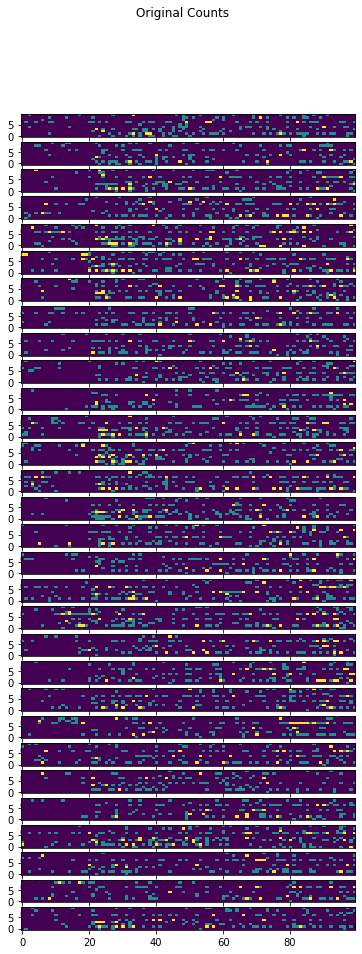

In [388]:
# Pick single trial
trial = np.arange(this_dat.shape[0])
count_data = this_dat_binned[trial]
#count_data = np.sum(this_dat_binned,axis=0)
n_count_data = count_data.shape[-1]

fig, ax = plt.subplots(len(trial),1, figsize = (6,15))
for this_ax, this_dat in zip(ax.flatten(),count_data):
    this_ax.imshow((this_dat>0)*1 + (this_dat>1), interpolation = 'nearest', aspect = 'auto', origin = 'lower')
plt.suptitle('Original Counts')

count_data = count_data>0
print(count_data.shape)
# Nrn X Time_bin

In [389]:
states = 5
split_list = np.array_split(count_data,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
mean_vals = np.mean(split_array,axis=(1,-1))
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
print(mean_vals)

(5, 10)
[[0.02833333 0.11166667 0.07333333 0.02333333 0.05       0.015
  0.19666667 0.03333333 0.125      0.095     ]
 [0.10166667 0.435      0.15833333 0.32166667 0.21166667 0.035
  0.355      0.05       0.105      0.12666667]
 [0.05333333 0.26666667 0.17833333 0.13333333 0.28333333 0.01666667
  0.32333333 0.035      0.105      0.13      ]
 [0.07666667 0.35666667 0.145      0.08833333 0.26833333 0.01666667
  0.35666667 0.04       0.12       0.13333333]
 [0.08666667 0.41       0.15       0.07833333 0.30666667 0.015
  0.47166667 0.105      0.14       0.13      ]]


In [390]:
idx = np.arange(n_count_data) # Index
array_idx = np.broadcast_to(idx, count_data.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
99
(30, 10, 100)


(5, 10)


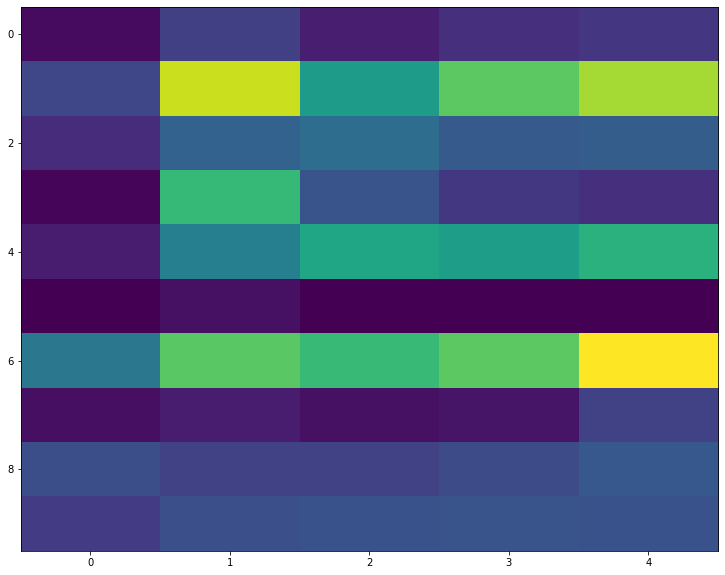

In [391]:

lambda_names = ['lambda_{}'.format(i+1) for i in range(states)]
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    #a_lambda = pm.HalfNormal('a_lambda', 2.)
    #b_lambda = pm.HalfNormal('b_lambda', 5.)
    a_lambda = 2
    b_lambda = 5
    
    lambda_latent = pm.math.stack(
                        [pm.Beta(lambda_names[i], a_lambda, b_lambda, testval = mean_vals[i], 
                                   shape = (mean_vals.shape[1])) \
                         for i in range(states)]
    )
    
print(lambda_latent.tag.test_value.shape)
plt.imshow(lambda_latent.tag.test_value.T,aspect='auto');

In [392]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.  19.8 39.6 59.4 79.2 99. ]
[0.2 0.4 0.6 0.8]


In [393]:
#tau_names = ['tau_{}'.format(i+1) for i in range(count_data.shape[0])]
tau_names = ['tau_{}'.format(i+1) for i in range(states-1)]
with model:
    
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3.)
    b = pm.HalfNormal('b_tau', 3.)
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb
    tau_latent = pm.math.stack([
                       pm.Beta(tau_names[i]+'_pre', a, b, 
                               shape = count_data.shape[0], testval = even_switches_normal[1+i]) \
                   for i in range(states-1)]).T.sort(axis=-1)
    print(tau_latent.tag.test_value.shape)
    #Sort changepoints for every trial
    #tau_latent = pm.Deterministic('tau_latent', tau_pre.T.sort(axis=-1))
    
    # Define transforms
#     Order = pm.transforms.Ordered() # The usual one that pymc3 automatically applies to bounded variables
#     Logodd = pm.transforms.LogOdds() # So that one changepoint is always ahead of the other
#     chain_tran = pm.transforms.Chain([Logodd, Order])
#     if states > 2:
#         tau_latent = \
#                pm.math.stack([
#                        pm.Beta(tau_names[i], a, b,
#                              shape = states-1, transform = chain_tran, 
#                                testval = even_switches_normal[1:states]) \
#                    for i in range(count_data.shape[0])])
#     else:
#         tau_latent = pm.Beta('tau_latent', a, b, shape = count_data.shape[0], testval = even_switches_normal[1])   
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Dirichlet distribution gives state lenghts
    #tau_latent = pm.Dirichlet('tau_latent', np.ones(states))[:3]
    # State lengths converted to switchpoint times
    #tau = pm.Deterministic('tau', idx_range * tt.extra_ops.cumsum(tau_latent)) # Gives end times of states
    
    
#print(tau_latent.tag.test_value)
print(tau.tag.test_value.shape)


(30, 3)
(30, 4)


(30, 10, 100)
(30, 10, 100)


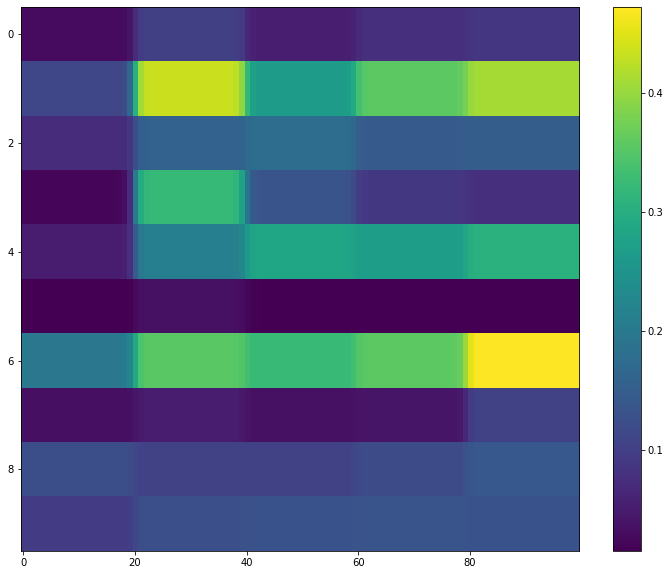

In [394]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,0][:,np.newaxis,np.newaxis]))
    weight_2_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,1][:,np.newaxis,np.newaxis]))
    weight_3_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,2][:,np.newaxis,np.newaxis]))
    weight_4_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,3][:,np.newaxis,np.newaxis]))
    
    # trial x time                             # 1 x time            # trial x 1                                       
    #weight_1_stack = tt.nnet.sigmoid(2 * (idx[np.newaxis,:] - tau[:,0][:,np.newaxis]))
    #weight_2_stack = tt.nnet.sigmoid(2 * (idx[np.newaxis,:] - tau[:,1][:,np.newaxis]))
    #weight_3_stack = tt.nnet.sigmoid(2 * (idx[np.newaxis,:] - tau[:,2][:,np.newaxis]))
    
    # trial x 1 x time
    #weight_1_stack = weight_1_stack[:,np.newaxis,:]
    #weight_2_stack = weight_3_stack[:,np.newaxis,:]
    #weight_2_stack = weight_3_stack[:,np.newaxis,:]
    
    #weight_stack = pm.math.stack([1 - weight_1_stack,
    #                             weight_1_stack * (1 - weight_2_stack),
    #                             weight_2_stack * (1 - weight_3_stack),
    #                             weight_3_stack])
    #lambda_ = pm.math.dot(weight_stack.T, lambda_latent).T.swapaxes(0,1)
    
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[1][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[2][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_3_stack * (1 - weight_4_stack), lambda_latent[3][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_4_stack, lambda_latent[4][np.newaxis,:,np.newaxis])

print(weight_1_stack.tag.test_value.shape)
#print(weight_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
plt.imshow(lambda_.tag.test_value[0],aspect='auto');plt.colorbar();

In [395]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Bernoulli("obs", lambda_, observed=count_data)

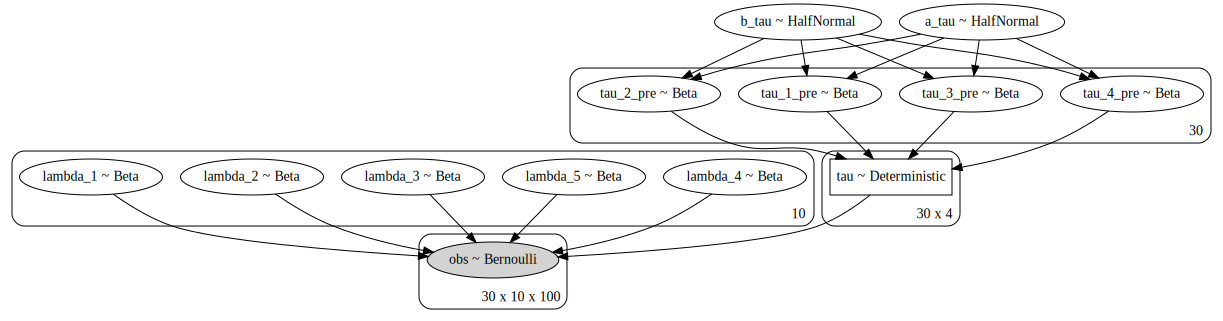

In [396]:
pm.model_to_graphviz(model)

In [ ]:
with model:
    #step= pm.Metropolis()
    trace = pm.sample(5000, tune=2500, 
                      #step = step,
                      chains = 16, cores = 16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau_4_pre, tau_3_pre, tau_2_pre, tau_1_pre, b_tau, a_tau, lambda_5, lambda_4, lambda_3, lambda_2, lambda_1]
Sampling 16 chains, 0 divergences:  13%|█▎        | 15364/120000 [43:19<5:58:23,  4.87draws/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limi

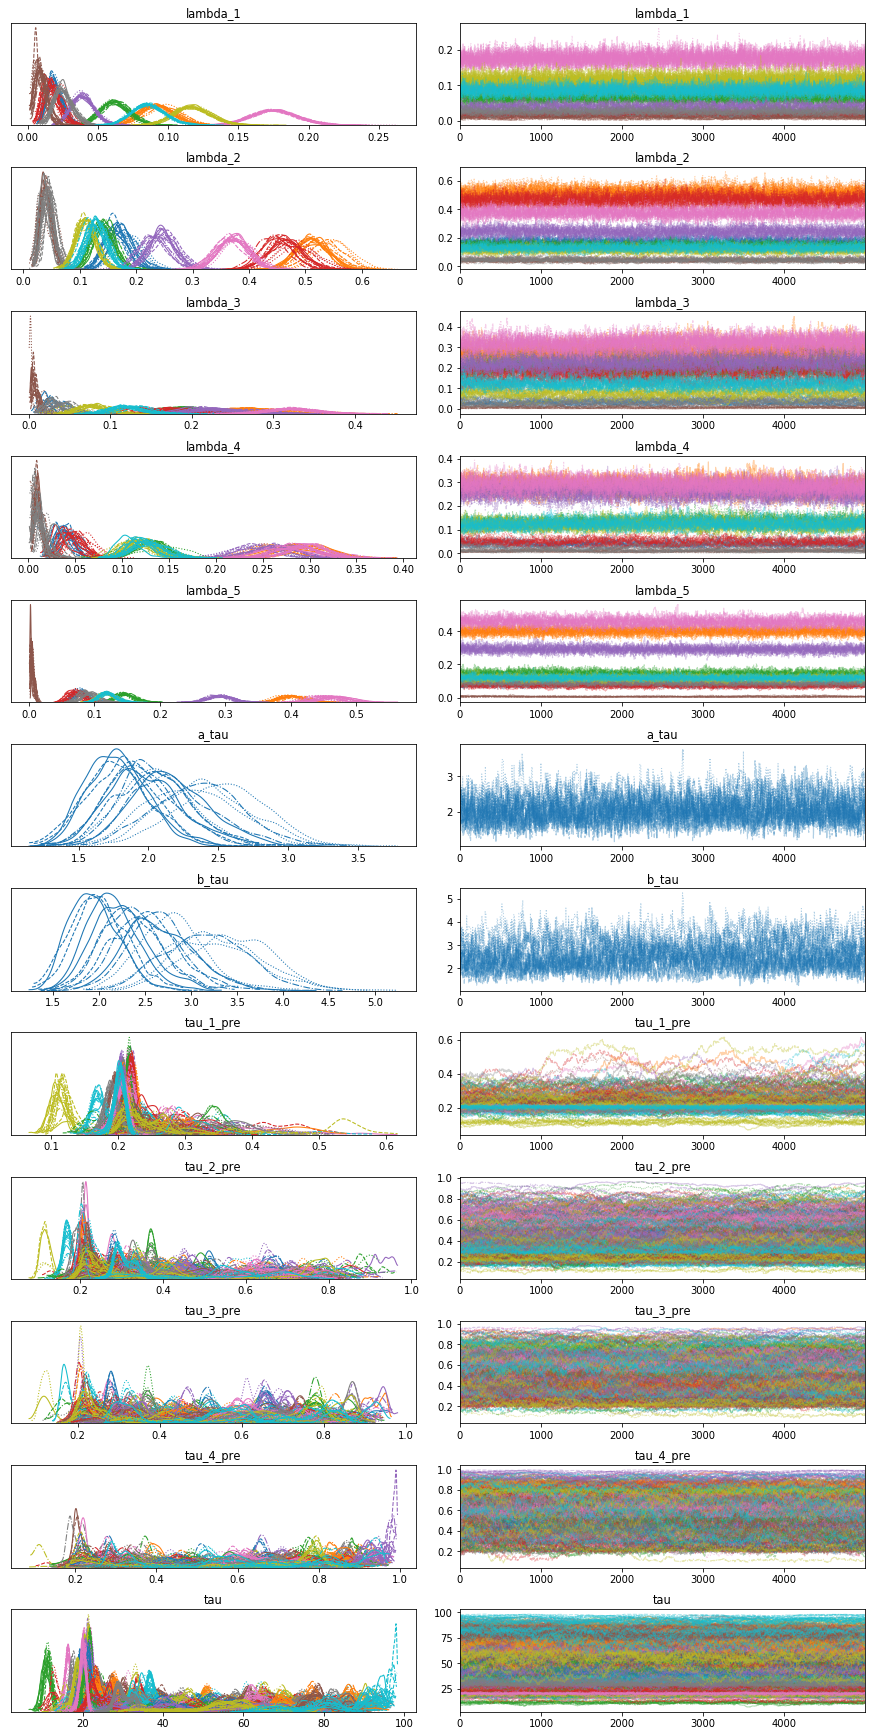

In [399]:
pm.traceplot(trace);

In [400]:
#pm.forestplot(trace[::100], combined=True, var_names = 'tau');

In [401]:
#pm.forestplot(trace[::100], combined=True, var_names = ['lambda_1','lambda_2','lambda_3','lambda_4']);

In [402]:
#pm.summary(trace[::100]).round(2)

In [404]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
lambda_3_samples = trace['lambda_3']
lambda_4_samples = trace['lambda_4']
lambda_5_samples = trace['lambda_5']
lambda_stack = np.stack([lambda_1_samples,
                            lambda_2_samples,
                            lambda_3_samples,
                            lambda_4_samples,
                            lambda_5_samples])
#tau_1_samples = trace['tau_1']
#tau_2_samples = trace['tau_2']
#tau_samples = np.stack([tau_1_samples, tau_2_samples])
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(80000, 30, 4)
(5, 80000, 10)


Text(0.5, 1.0, 'Zscored')

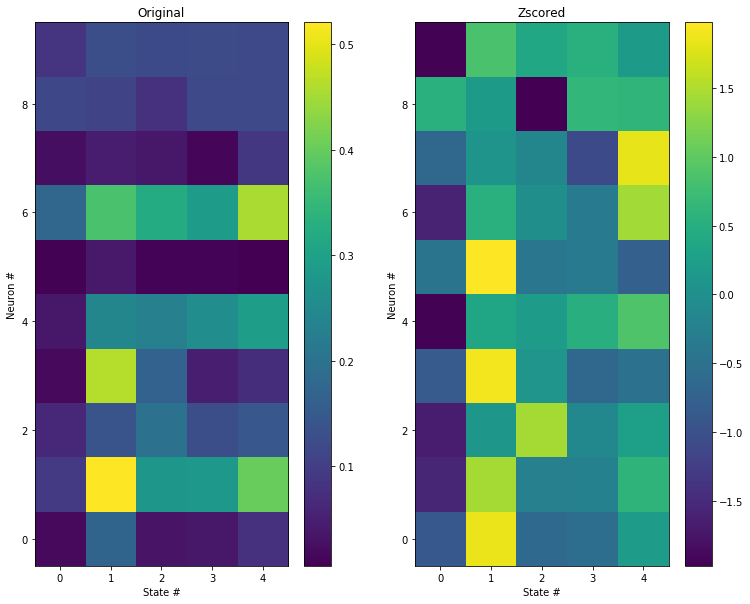

In [405]:
mean_lambda = np.mean(lambda_stack,axis=1)
fig = plt.figure()
ax = fig.add_subplot(121)
plt.imshow(mean_lambda.T, aspect='auto', origin='lower');plt.colorbar();
plt.xticks(np.arange(mean_lambda.shape[0]));
plt.xlabel('State #');
plt.ylabel('Neuron #');
plt.title('Original')
ax = fig.add_subplot(122)
plt.imshow(stats.zscore(mean_lambda.T,axis=-1), aspect='auto', origin='lower');plt.colorbar();
plt.xticks(np.arange(mean_lambda.shape[0]));
plt.xlabel('State #');
plt.ylabel('Neuron #');
plt.title('Zscored')

In [406]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:10<00:00, 185.95it/s]


(2000, 30, 10, 100)

In [407]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)

(30, 10, 100)


(30, 4)


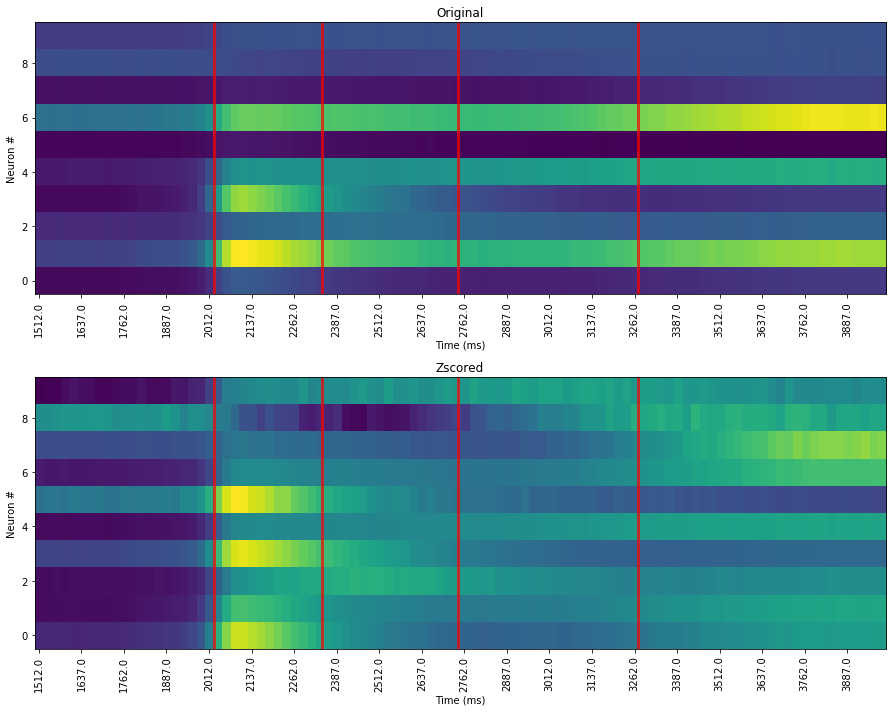

In [408]:
mean_tau = np.mean(tau_samples,axis=0)
print(mean_tau.shape)
tick_interval = 5
fig = plt.figure()
ax = fig.add_subplot(211)
ax.imshow(np.mean(mean_ppc,axis=0), aspect='auto', origin='lower')
plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
plt.vlines(np.mean(mean_tau,axis=0),-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7);
plt.xlabel('Time (ms)');
plt.ylabel('Neuron #');
plt.title('Original')
ax = fig.add_subplot(212)
ax.imshow(stats.zscore(np.mean(mean_ppc,axis=0),axis=-1), aspect='auto', origin='lower')
plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
plt.vlines(np.mean(mean_tau,axis=0),-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7);
plt.xlabel('Time (ms)');
plt.ylabel('Neuron #');
plt.title('Zscored')
plt.tight_layout()

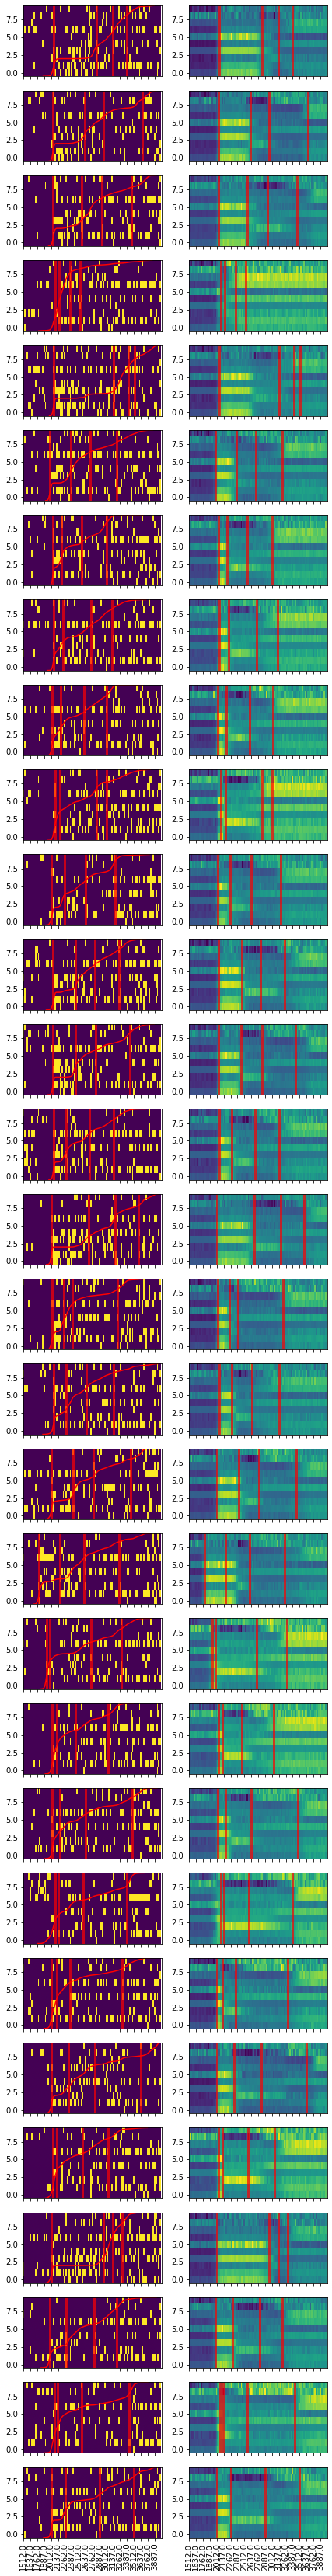

In [409]:
# Overlay raster with CDF of switchpoints
zscore_mean_ppc = np.stack([stats.zscore(mean_ppc[:,nrn],axis=None) for nrn in range(mean_ppc.shape[1])]).swapaxes(0,1)
fig, ax = plt.subplots(count_data.shape[0],2, figsize = (7,60),sharex=True)
for trial in range(count_data.shape[0]):
    ax[trial,0].imshow(count_data[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[trial,1].imshow(zscore_mean_ppc[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[trial,1].vlines(mean_tau[trial],-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

    fin_prob,this_x = np.histogram(tau_samples[:,trial].flatten(),100)
    cum_prob = np.cumsum(fin_prob)
    ax[trial,0].plot(this_x[1:],(cum_prob/np.max(cum_prob)*count_data.shape[1])-0.5, c = 'red');
    ax[trial,0].vlines(mean_tau[trial],-0.5,count_data.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

for col in range(2):
    plt.sca(ax[-1,col])
    plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
    plt.xlim(0,len(binned_t_vec))

In [412]:
# For visualization
# Take firing around each transition and stack it together
window_radius_time = 400 # ms
window_radius_bins = window_radius_time//bin_width
print(window_radius_bins)

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau)

# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
aligned_spikes = np.ones((*count_data.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_spikes.shape)
for trial in range(count_data.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < count_data.shape[-1]) + \
                                            count_data.shape[-1] * (upper_bound > count_data.shape[-1])
        
        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = count_data[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = count_data[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        aligned_spikes[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_spikes[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window


16
(30, 10, 4, 32)


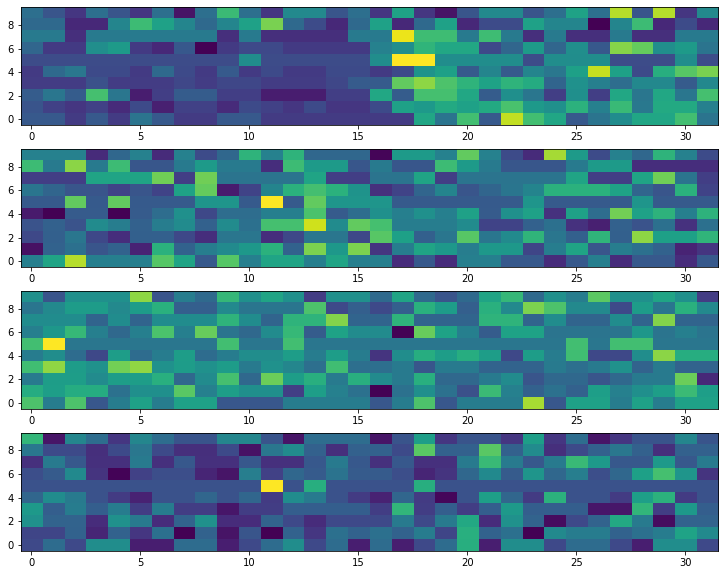

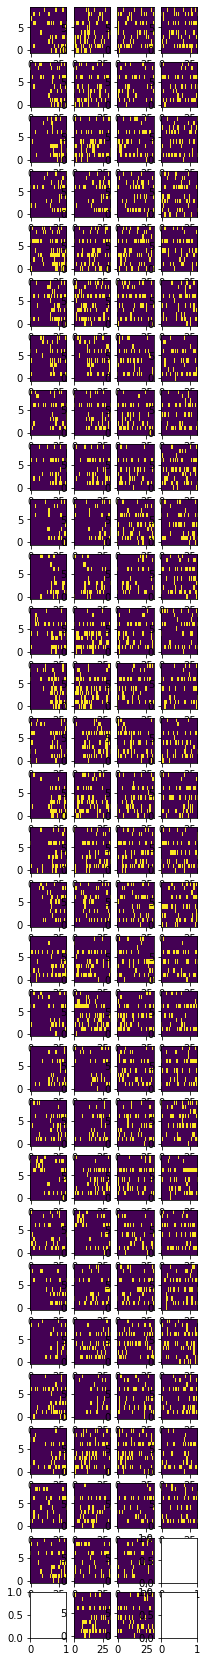

In [413]:
# Stack trial vertically and switchpoints horizontally
# Remove trials with missing time
# Make lists of acceptable trials
acceptable_trials = [[trial for trial in aligned_spikes[:,:,this_switch] if -1 not in trial]\
                    for this_switch in range(aligned_spikes.shape[2])]
fig, ax = plt.subplots(aligned_spikes.shape[2])
for switch_num, this_switch in enumerate(acceptable_trials):
    ax[switch_num].imshow(stats.zscore(np.mean(this_switch,axis=0),axis=-1), aspect='auto', origin='lower');
    
fig, ax = plt.subplots(aligned_spikes.shape[0], aligned_spikes.shape[2], figsize = (3,30))
for switch_num, this_switch in enumerate(acceptable_trials):
   for trial_num, this_trial in enumerate(this_switch):
       ax[trial_num, switch_num].imshow(this_trial, aspect='auto', origin='lower');